In [90]:
import pandas as pd 
smallest_index = 515
# get clean plant data
df = pd.read_excel("ultratech_data_clean.xlsx")
df = df.iloc[0:,0:19]
df = df.drop(["A", "B", "a", "group","resnorm"], 1)
df = df.dropna()
df = df[((df.Q_f>100))]
df = df[((df.Q_p < 100))]
df = df[((df.Q_p > 50))]
df = df[((df.index < 4000 and df.index >1000))]
df["C_f"] = df["C_f"]*0.64
df["C_p"] = df["C_p"]*0.64
df["Cond. At ERT to RWST [AIT - 005] [µS/cm]"] = df["Cond. At ERT to RWST [AIT - 005] [µS/cm]"]*.64
df["SP"] = df["C_p"]/df["C_f"]*100
df.head()

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [ ]:
import numpy as np
from posm import osmotic_pressure_TX

#got to calculate the change in %salt passage, product flow rate and Feed Side Pressure drop
# to calculate % salt passage 



class FouledLoss():    
    
    def __init__(self,Q_p, Q_f, Temp, Conc_f, Conc_p, P_f, P_p, dp, MembraneTempCoeff = 3000):
        
        #Calculate Baseline Normalized SP.
        self.SP = Conc_p/Conc_f*100
        #Calculate Baseline TempCorrectionFactor
        self.TCF =  np.exp(MembraneTempCoeff*(1/298.16-1/(Temp+273.15))) 
        #Calculate Baseline Osmotic pressures
        OB_f = osmotic_pressure_TX(Conc_f, Temp)
        OB_p = (0.0117*Conc_p-34)/14.23*(Temp+320)/345
        self.TransPSI = P_f-dp/2-P_p-OB_f+OB_p
        #Save all Baseline Values to be used to compare to realtime
        self.Q_p = Q_p #m3/hr
        self.Q_f = Q_f #m3/hr
        self.Temp = Temp #degrees C
        self.Conc_f = Conc_f #ppm
        self.Conc_p = Conc_p #ppm
        self.P_f = P_f
        self.P_p = P_p
        self.DP = dp
        #pressure values. Store these along with baseline values.

        
    def PermFlowFactor(self,Temp, Conc_f, Conc_p, P_f, P_p, dp, MembraneTempCoeff = 3000):                
        
        #Returns the Factor by which the current flow rate would have to be multiplied to achieve a normalized value
        TCF =  np.exp(MembraneTempCoeff*(1/298.16-1/(Temp+273.15))) 
        OB_f = (0.0117*Conc_f-34)/14.23*(Temp+320)/345
        OB_p = (0.0117*Conc_p-34)/14.23*(Temp+320)/345
        TransPSI = P_f-dp/2-P_p-OB_f+OB_p
        return TransPSI/self.TransPSI*TCF/self.TCF
    
    def SaltPassFactor(self,Q_p, Q_f, Temp, Conc_f, MembraneTempCoeff=3000):
        #returns the factor by which the salt passage percentage would have to be multiplied to achieve a normalized value
        TCF =  np.exp(MembraneTempCoeff*(1/298.16-1/(Temp+273.15)))
        CFCs = self.Conc_f*np.log(1/(1-self.Q_p/self.Q_f))
        CFCa = Conc_f*np.log(1/(1-Q_p/Q_f))
        return Q_p/self.Q_p*CFCs/CFCa*TCF/self.TCF*Conc_f/self.Conc_f
    
    def StandardPerformance(self,Q_p, Q_f, Temp, Conc_f, Conc_p, P_f, P_p, dp, MembraneTempCoeff = 3000):
        SP = self.SP*self.SaltPassFactor(Q_p, Q_f, Temp, Conc_f, MembraneTempCoeff=3000)
        NF = self.Q_p*self.PermFlowFactor(Temp, Conc_f, Conc_p, P_f, P_p, dp, MembraneTempCoeff = 3000)
        
        return(NF, SP)

        
    
        
    

In [ ]:
checker = FouledLoss(df.at[515,"Q_p"],df.at[515,"Q_f"],df.at[515,"T_f"],df.at[515,"C_f"],df.at[515,"C_p"],
                    df.at[515,"P_f"],1,df.at[515,"dp"])

In [ ]:
df["Qpi"], df["SPi"] = checker.StandardPerformance(df["Q_p"],df["Q_f"], df["T_f"],df["C_f"],df["C_p"],df["P_f"],1,df["dp"])


In [ ]:
df1 = df.set_index("Datetime")

In [ ]:
import matplotlib.pyplot as plt
plt.plot(df1.Q_p, color="r")
plt.plot(df1.Qpi, color="b")
plt.show()
plt.plot(df1.SP, color="r")
plt.plot(df1.SPi, color="b")
plt.show()



In [ ]:
plt.plot(df.Q_f)
plt.plot(df.Q_p)

In [ ]:
class Potential():
    def __init__(self,Q_p, Q_f, Temp, Conc_f, Conc_p, P_f, P_p, dp, MembraneTempCoeff = 1):
        
        #Calculate Baseline Normalized SP.
        self.SP = Conc_p/Conc_f*100
        #Calculate Baseline TempCorrectionFactor
        self.TCF = np.exp(MembraneTempCoeff*(1/298.16-1/(Temp+273.15))) 
        #Calculate Baseline Osmotic pressures
        OB_f = osmotic_pressure_TX(Conc_f, Temp)
        OB_p = osmotic_pressure_TX(Conc_p, Temp)
        self.TMP = P_f-(dp/2+P_p+OB_f)
        self.AS = Q_p/self.TMP
        #Save all Baseline Values to be used to compare to realtime
        #pressure values. Store these along with baseline values.
        
    def QnewMembranes(self, TMP, TCF):
        #this function apploes the actual transmembrane pressure and temp to the Reference membrane 
        return TMP*self.AS*TCF
    def QrefConditions(self, AS, TMP):
        #this function applies the reference conditions to the current membrane
        return TMP*AS*self.TCF
    def QrefPressures(self, AS, TCF):
        #this function only changes out the current TMP for the reference TMP
        return self.TMP*AS
    def Flow(self,Q_p, Q_f, Temp, Conc_f, Conc_p, P_f, P_p, dp, MembraneTempCoeff = 1):
        #Calculate Baseline Normalized SP.
        SP = Conc_p/Conc_f*100
        #Calculate Baseline TempCorrectionFactor
        TCF = np.exp(MembraneTempCoeff*(1/298.16-1/(Temp+273.15))) 
        #Calculate Baseline Osmotic pressures
        OB_f = osmotic_pressure_TX(Conc_f, Temp)
        OB_p = osmotic_pressure_TX(Conc_p, Temp)
        TMP = P_f-(dp/2+P_p+OB_f)
        AS = Q_p/TMP
        NM = self.newMembranes(TMP, TCF)
        RC = self.refConditions(AS, TMP)
        RP = self.refPressures(AS, TCF)
        return (NM, RC, AS, RP)
 
    


In [ ]:
checker = Potential(df.at[515,"Q_p"],df.at[515,"Q_f"],df.at[515,"T_f"],df.at[515,"C_f"],df.at[515,"C_p"],
                    df.at[515,"P_f"],1,df.at[515,"dp"])

In [ ]:
df["NM"], df["RC"], df["AS"], df["RP"] = checker.values(df["Q_p"],df["Q_f"], df["T_f"],df["C_f"],df["C_p"],df["P_f"],1,df["dp"])

In [ ]:

fig, ax = plt.subplots(3, figsize=(10,20))
ax[0].plot(df.Datetime, df["NM"], c="r", label="Theoretical yield with new membranes")
ax[0].plot(df.Datetime, df["RC"],c="g", label="Theoretical yield under reference conditions")
ax[0].plot(df.Datetime, df["Q_p"],c="b", label="Actual Qp")
ax[0].plot(df.Datetime, df["RP"],c="black", label="Theoretical yield under reference pressures")
ax[0].legend()
ax[0].set_title("Flow Rate Vs. Time")
ax[0].set_xlabel("Time")
ax[0].set_ylabel("Flow Rate [M3/hr]")
fig.show()
ax[1].plot(df.Datetime, df["AS"])
ax[1].set_xlabel("Time")
ax[1].set_ylabel("A*Surface Area")
ref = []
for n in df["AS"]:
    ref.append(checker.AS)
ax[1].plot(df.Datetime, ref)
ax[2].plot(df.Datetime, df.T_f)
ax[2].set_ylabel("Temp")
print("""A*S over time might be a good alternative to normalized flow rate. It seems to show fouling over time and 
      seems to show when the system was recalibrated, cleaned and when the membranes were replaced """)


In [91]:
import numpy as np
class ReverseNormalize():
    def __init__(self):
        #layout the factors that I want for the functions
        pass
    def set_reference(self,Q_p, Q_f, Temp, Conc_f, Conc_p, P_f, P_p, dp):      
        self.Temp = Temp
        self.Qp = Q_p
        self.Qf = Q_f
        self.Cf = Conc_f
        self.Cp = Conc_p
        self.Pf = P_f
        self.Pp = P_p
        self.dp = dp
        self.Tcf = self.TCF(Temp)
    
    def TCF(self, T):
        temps = []
        try:
            for t in T:
                if t<25:
                    temps.append(np.exp(3020*(1/(298)-1/(273+t))))
                else:
                    temps.append(np.exp(2640*(1/(298)-1/(273+t))))
        except:
            if T<25:
                temps = np.exp(3020*(1/298-1/(273+T)))
            else:
                temps = np.exp(2640*(1/298-1/(273+T)))
        return temps
    def TMP(self, Pf, Pp, dp, Cf, Cp, Temp):
        OB_f = osmotic_pressure_TX(Cf, Temp)
        OB_p = osmotic_pressure_TX(Cp, Temp)
        TMP = Pf-(dp/2+Pp+OB_f-OB_p)
        return TMP
    
    def SPnorm(self, Qp, TCF, Cf):
        return Qp/self.Qp/TCF/self.Tcf*Cf/self.Cf
    
    def DPnorm(self,Qf, Qp):
        return (2*self.Qf-self.Qp)/(2*Qf-Qp)
    
    def Concentrate(self,Cf, Pf, Cp, Qp, Qf):
        Cfc = -Cf*np.log(1-Qp/Qf)/(Qp/Qf)
        R = (Cf-Cp)/Cf
        return Cfc/Cf*Pf-(1-R)
    
    def SPB(self, SP, TCF, Qp):
        return SP/TCF*Qp
    
    def Flow(self,Qp, Qf, Temp, Cf, Cp, Pf, Pp, dp):
        TCF = self.TCF(Temp)
        TMP = self.TMP(Pf, Pp, dp, Cf, Cp, Temp)
        AS = Qp/TMP
        TCFref = self.Tcf
        TMPref = self.TMP(self.Pf, self.Pp, self.dp, self.Cf, self.Cp, self.Temp)
        ASref = self.Qp/TMPref
        Qrefpress = TMPref*AS
        QNM = TMP*ASref
        Qtemp = TMP*AS
        return Qrefpress, QNM, Qtemp
    
    def SP(self, Cf, Cp, Qf, Qp, T):
        SP = Cp/Cf*100
        self.Sp = self.Cp/self.Cf*100
        TCF =  self.TCF(T)
        TCFref = self.TCF(self.Temp)
        B = self.SPB(SP, TCF, Qp)
        Bref = self.SPB(self.Sp,TCFref,self.Qp)
        SPtemp = B*TCFref/Qp
        SPNM = Bref*(TCF/Qp)
        return SP, SPtemp, SPNM
    
    def DP(self,Qp, Qf, T):
        TCF = self.TCF(T)
        DPNM = self.dp/self.DPnorm(Qf, Qp)
        return DPNM

In [92]:
RV = ReverseNormalize()
RV.set_reference(df.at[smallest_index,"Q_p"],df.at[smallest_index,"Q_f"],df.at[smallest_index,"T_f"],df.at[smallest_index,"C_f"],df.at[smallest_index,"C_p"],
                    df.at[smallest_index,"P_f"],1,df.at[smallest_index,"dp"])

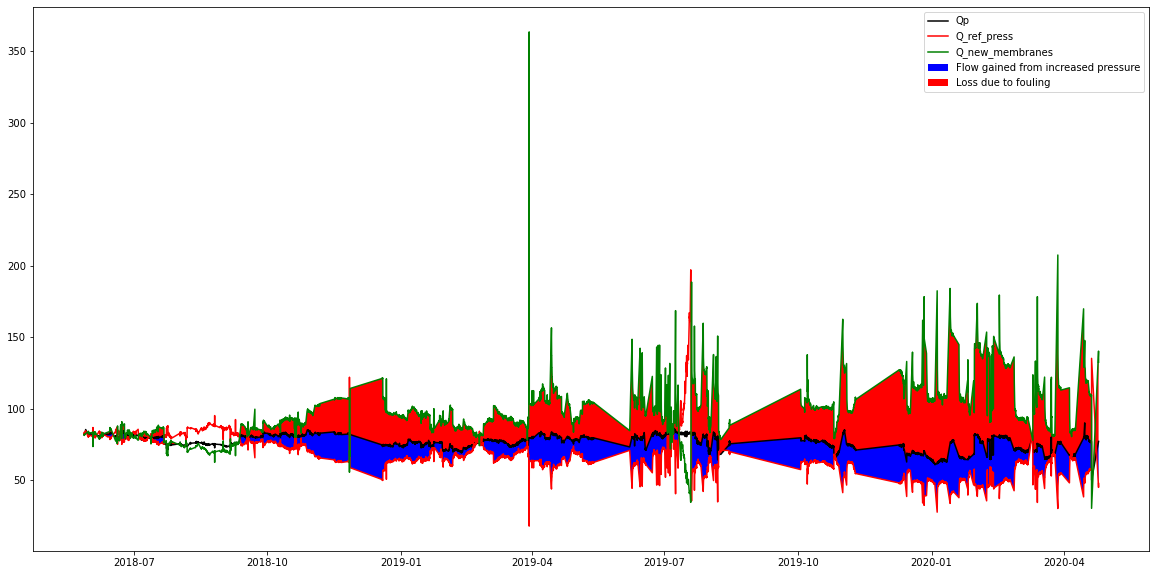

In [93]:
Qp, QNM, Qt = RV.Flow(df["Q_p"],df["Q_f"], df["T_f"],df["C_f"],df["C_p"],df["P_f"],1,df["dp"])
figure = plt.figure(figsize=(20,10))
plt.plot(df.Datetime, df.Q_p, c="black", label="Qp")
plt.plot(df.Datetime, Qp, c="r", label="Q_ref_press")
plt.plot(df.Datetime, QNM, c="g", label="Q_new_membranes")
plt.fill_between(df.Datetime, df.Q_p, Qp, where=df.Q_p>=Qp, facecolor="blue", interpolate=True, label="Flow gained from increased pressure" )
plt.fill_between(df.Datetime, df.Q_p, QNM, where=df.Q_p<=QNM, facecolor="red", interpolate=True, label="Loss due to fouling" )
plt.legend()
plt.show()

Text(0, 0.5, 'Salt Passage')

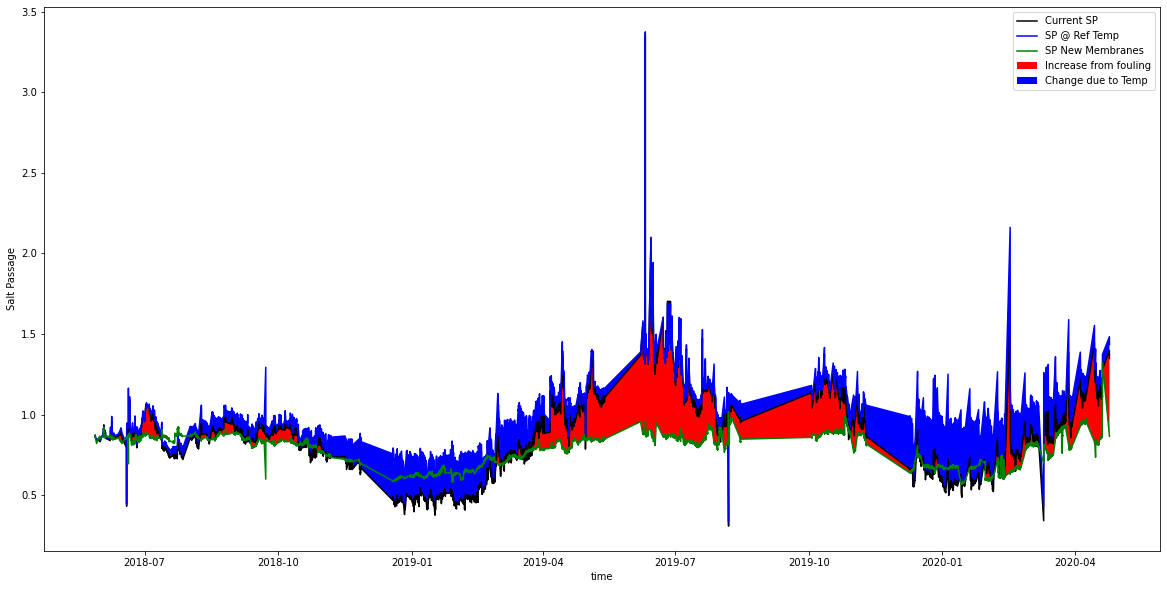

In [94]:
SP, SPtemp, SPNM = RV.SP(df["C_f"], df["C_p"], df["Q_f"], df["Q_p"], df["T_f"])
figure = plt.figure(figsize=(20,10))
plt.plot(df.Datetime, SP, c="black", label="Current SP")
plt.plot(df.Datetime, SPtemp, c="b",label="SP @ Ref Temp" )
plt.plot(df.Datetime, SPNM, c="g", label="SP New Membranes" )
plt.fill_between(df.Datetime, SP, SPNM, where=SP>=SPNM, facecolor="red", interpolate=True, label="Increase from fouling" )
plt.fill_between(df.Datetime, SP, SPtemp, where=SP<=SPtemp, facecolor="blue", interpolate=True, label="Change due to Temp" )
plt.legend()
plt.xlabel("time")
plt.ylabel("Salt Passage")


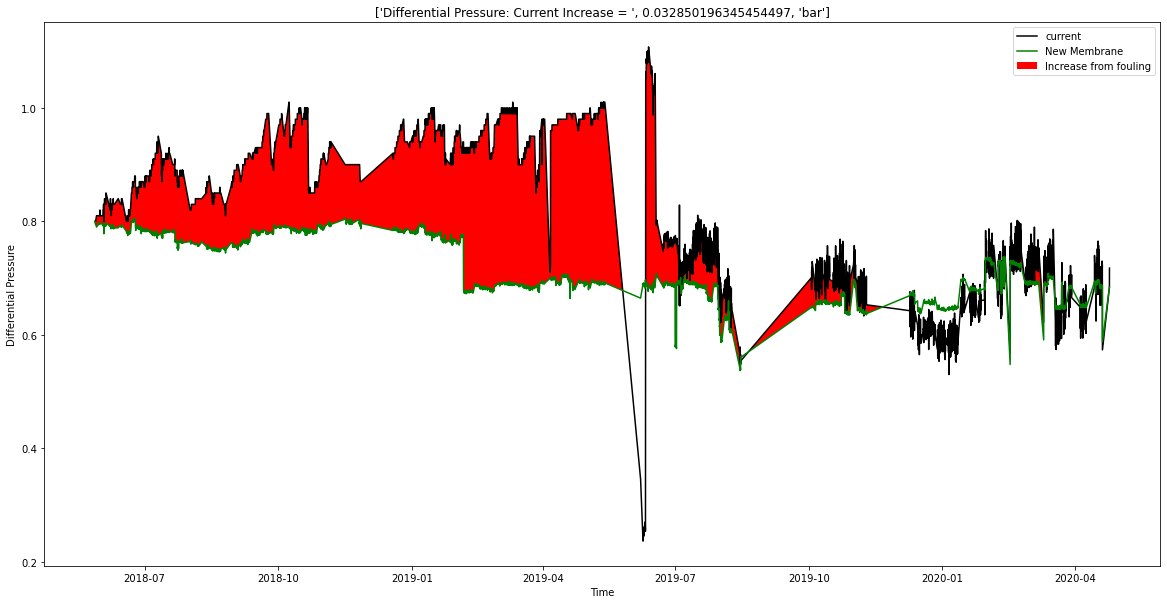

In [95]:
DPNM = RV.DP(df.Q_p, df.Q_f, df.T_f)
figure = plt.figure(figsize=(20,10))
plt.plot(df.Datetime, df.dp, c="black", label="current")
plt.plot(df.Datetime, DPNM, c="g", label="New Membrane")
plt.fill_between(df.Datetime, df.dp, DPNM, where=df.dp>=DPNM, facecolor="red", interpolate=True, label="Increase from fouling" )
plt.ylabel("Differential Pressure")
plt.xlabel("Time")
plt.title(["Differential Pressure: Current Increase = ", df.dp.iloc[-1]-DPNM.iloc[-1], "bar"])
plt.legend()
plt.show()


In [96]:
df.dp.iloc[-1]

0.717752457